# Poiseuille - BGK - Zou-He Constant Velocity Inlet and Outlet

In [11]:
# Python Imports
from pylab import *
import numpy as np
import matplotlib.pylab as plt
import matplotlib.colors
from IPython.display import display, Math, Latex

## Setting Simulation

### Lattice Paremeters

In [12]:
w0=4.0/9.0;w1=1.0/9.0;w2=1.0/36.0; # Lattice Weights
w = np.array([w0,w1,w1,w1,w1,w2,w2,w2,w2],dtype="float64") 
cx = np.array([0,1,0,-1, 0,1,-1,-1, 1],dtype="int8")  # Lattice Directions
cy = np.array([0,0,1, 0,-1,1, 1,-1,-1],dtype="int8")  # Lattice Directions
opp = np.array([0,3,4,1,2,7,8,5,6],dtype="uint8")  # Opposite Lattice Directions

### Problem Scaling: From Dimensionless to LBM Scale

In [13]:
#------------Dimensionless Parameter For Pro----------------
uo = 1.0 # Dimensionless Velocity
ho = 1.0 # Dimensionless Domain Length
Re = 10.0 # Reynolds Number
nuo = uo*ho/Re #Dimensionless Kinematic Viscosity

The problem scaling follow the equations:
$$
\Delta x=\frac{H_{0}}{Nx}, \quad \quad r=\frac{\Delta x}{\Delta t}, \quad \quad u=u_{0}\frac{\Delta t}{\Delta x}, \quad \quad \textrm{and} \quad \quad \nu=\nu_{0}\frac{\Delta t}{\Delta x^{2}}
$$
where $\Delta x $ is grid size, $\Delta y$ is time step and $r$ is the relation term. Dimensionless numbers
$$
Re=\frac{u_{0}\rho H}{\mu}=\frac{u_{0} H}{\nu} \quad \quad \textrm{and} \quad \quad C_{d}=\frac{24}{Re}\frac{L}{H}.
$$

In [14]:
import time
#---------------Numerical Domain Size--------------------
cases=3
Nx0 = np.array([10, 20, 40],dtype="int64")
Ny0 = np.array([12, 22, 42],dtype="int64")
r0 = np.array([2.0**(3), 2.0**(4), 2.0**(5)],dtype="float64")
mstep=10000
mstep0 = np.array([mstep*4**(0), mstep*4**(1), mstep*4**(2)],dtype="int64")
rhor = np.empty(len(Nx0), dtype=object)
Vxr = np.empty(len(Nx0), dtype=object)
Vyr = np.empty(len(Nx0), dtype=object)
Cdr = np.zeros((3),dtype="float64")
Mass = np.empty(len(Nx0), dtype=object)
for i in range(len(Nx0)):
    rhor[i] = np.zeros((int(Nx0[i]), int(Ny0[i])), dtype="float64")
    Vxr[i] = np.zeros((int(Nx0[i]), int(Ny0[i])), dtype="float64")
    Vyr[i] = np.zeros((int(Nx0[i]), int(Ny0[i])), dtype="float64")
    Mass[i] = np.zeros((int(mstep0[i])), dtype="float64")
for case in range(0,cases):
    Nx=Nx0[case]
    Ny=Ny0[case]
    #------------------------------------------Scaling Term--------------------------------------------
    dx = ho / (Ny-2) # Grid size 
    r = r0[case] # Relation term r=dx/dt
    dt = dx / r # Time Step
    #----------------------------------------LBM-Scale-----------------------------------------------
    nu = dt * nuo / (dx * dx)  #Scaling Viscosity
    ue = dt * uo / dx  #Scaling Velocity
    cs = 1.0 / sqrt(3.) #Sound Speed
    tau = (nu/ (cs * cs)) + (1.0/ 2.0) #Relaxation time
    rhoi = 1.0 #Initial Densty
    #--------------Print-Data-------------------------------------------------------------------------
    display(Math(r"\tau="+str(tau)+r"\quad\quad \nu="+str(nu)))
    display(Math(r"r="+str(r)+r"\quad\quad \overline{u}="+str(ue)))
    display(Math(r"dx="+str(dx)+r"\quad\quad dt="+str(dt)))
    #----------------Allocating array of solid nodes------------------------------------------------
    solid=np.ones((Nx,Ny),dtype="uint8") # Binary array to allocate the mapp of pore and solid # Parallel Plates
    solid[:,0] = 0
    solid[:,Ny-1] = 0
    #--------Allocating "imapp" array ti store the information of lattice directions that need be 
    # inverted during the Half-way Bounce-Back method.
    imapp=np.zeros((9,Nx,Ny),dtype="uint8") #Interface mapping for Half-Way Bounce-Back
    for i in range(0,Nx):
        for j in range (0, Ny):
            if (solid[i,j]==1):
                for k in range (0,9):
                    #-----------------------------------------
                    ii=i+cx[k] 
                    if (ii>Nx-1):ii=0
                    if (ii<0):ii=Nx-1
                    #-----------------------------------------
                    jj=j+cy[k] 
                    if (jj>Ny-1):jj=0
                    if (jj<0):jj=Ny-1
                    #-----------------------------------------
                    if (solid[ii,jj]==0):
                        imapp[k,i,j]=k
    #---------------------Field-Arrays---------------------------------------------------------------- 
    rho=np.zeros((Nx,Ny),dtype="float64") # Allocating Density field
    rho[:,:]=np.where(solid==1,rhoi,0.0) # Constant initial density field
    rhow=np.zeros((Ny),dtype="float64") # Allocating West Boundary Density
    rhoe=np.zeros((Ny),dtype="float64") # Allocating East Boundary Density
    up=np.zeros((Ny),dtype="float64") # Allocating Boundary Parabolic Profile
    y=np.linspace(0.5, Ny-2 -0.5, Ny-2)
    up[1:-1]=6.0 * ue * ( y/float(Ny - 2) - ( y/float(Ny - 2) )**2 );
    Vx=np.zeros((Nx,Ny),dtype="float64") # Allocating Null Velocity x Field
    Vy=np.zeros((Nx,Ny),dtype="float64") # Allocating Null Velocity y Field
    #----------------Initializing Distribution Functions----------------
    f=np.zeros((9,Nx,Ny),dtype="float64") # Allocating Pre-Collisional Distribution Function
    fp=np.zeros((9,Nx,Ny),dtype="float64") # Allocating Pos-Collisional Distribution Function
    feq=np.zeros((9,Nx,Ny),dtype="float64") # Allocating Pos-Collisional Distribution Function
    for k in range (0,9):
        f[k,:,:]=np.where(solid==1,w[k]*rho[:,:],0.0)
    #---------------------------------Main-Loop-------------------------------------------------------
    Cd=0.0; Cd0=0.0
    tolerance=0.000001
    start=time.time()
    #---------------------------------Main-Loop-------------------------------------------------------------------------------------
    for kk in range(0,mstep0[case]):
        f_last  = f
        #------------------------------------Collision-----------------------------------------------------------------------------
        for k in range(0,9):
            feq[k,:,:]=w[k]*rho*(1. + 3.*(Vx*cx[k]+Vy*cy[k]) + 4.5*(Vx*cx[k]+Vy*cy[k])**2-1.5*(Vx*Vx+Vy*Vy))
            fp[k,:,:]=np.where(solid==1, f[k,:,:]-(1.0/tau)*(f[k,:,:]-feq[k,:,:]), 0.0 )
        #----------------------------------Streaming---------------------------------------------------------------------------
        for k in range(0,9):
            f[k,:,:]=np.roll(np.roll(fp[k,:,:], cx[k], axis=0), cy[k], axis=1)
        #--------------------------------------Half-Way-------------------------------------------------------------------------
        for k in range(1,9):
            f[k,:,:]=np.where(imapp[opp[k],:,:]==opp[k],fp[opp[k],:,:],f[k,:,:])
        #--------------------------------------Zou-He-BC------------------------------------------------------------------------
        #--------------------Inlet------------------------------------------------------------
        rhow= (f[0,0,:] + f[2,0,:] + f[4,0,:] + 2 * (f[3,0,:] + f[6,0,:] +f[7,0,:]) )/(1.0-up)
        f[1,0,:] = f[3,0,:] + 2.0*rhow*up/3.0
        f[5,0,:] = f[7,0,:] - (f[2,0,:]-f[4,0,:])/2.0 + rhow*up/6.0
        f[8,0,:] = f[6,0,:] + (f[2,0,:]-f[4,0,:])/2.0 + rhow*up/6.0
        #--------------------Outlet------------------------------------------------------------
        #--------------------Outlet (Convective Wang)---------------------------------------------------
        k_list = [3, 6, 7]
        f[k_list, Nx-1, :] = (f_last[k_list, Nx-1, :] + ue * f[k_list, Nx-2, :]) / (1.0 + ue)

        #--------------------------------------Macro-Properties------------------------------------------------------------------
        rho=np.where(solid==1,np.einsum('ixy->xy', f),0.0) 
        Vx=np.divide(np.einsum('i,ixy->xy', cx, f), rho, out=np.zeros_like(Vx, dtype="float64"), where=rho!=0)
        Vy=np.divide(np.einsum('i,ixy->xy', cy, f), rho, out=np.zeros_like(Vy, dtype="float64"), where=rho!=0)
        #-------------------------------------Convergence------------------------------------------------------------------------
        rho_med = np.sum(rho)/(Nx*(Ny-2))
        Mass[case][kk] = rho_med
        if (kk%1000==0):
            Umed = np.sum(Vx)/(Nx*(Ny-2))
            rho_med = np.sum(rho)/(Nx*(Ny-2))
            dp = (sum(rho[0,:]) - sum(rho[Nx-1,:]))*cs**2/(Ny-2)
            Cd=dp/(rho_med*Umed**2/2.0)
            print('Da=',Cd,'\t Diff=',np.fabs(Cd-Cd0),'\t Umed=',Umed,'\t Erro=',np.fabs(Cd-24.0/Re))
            # if(np.fabs(Cd-Cd0)<tolerance):
            #     break
            Cd0=Cd
    Cdr[case]=Cd
    rhor[case]=rho
    Vxr[case]=Vx
    Vyr[case]=Vy

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Da= 616.0614643928451 	 Diff= 616.0614643928451 	 Umed= 0.012562499999999999 	 Erro= 613.6614643928451
Da= 1.9086357625049069 	 Diff= 614.1528286303402 	 Umed= 0.11970601787882536 	 Erro= 0.49136423749509306
Da= 1.908635762504889 	 Diff= 1.7763568394002505e-14 	 Umed= 0.11970601787882534 	 Erro= 0.4913642374951108
Da= 1.9086357625048924 	 Diff= 3.3306690738754696e-15 	 Umed= 0.11970601787882536 	 Erro= 0.4913642374951075
Da= 1.9086357625048878 	 Diff= 4.6629367034256575e-15 	 Umed= 0.11970601787882533 	 Erro= 0.49136423749511215
Da= 1.9086357625049137 	 Diff= 2.5979218776228663e-14 	 Umed= 0.11970601787882529 	 Erro= 0.4913642374950862
Da= 1.9086357625048989 	 Diff= 1.4876988529977098e-14 	 Umed= 0.11970601787882533 	 Erro= 0.49136423749510105
Da= 1.9086357625049024 	 Diff= 3.552713678800501e-15 	 Umed= 0.11970601787882534 	 Erro= 0.4913642374950975
Da= 1.9086357625049044 	 Diff= 1.9984014443252818e-15 	 Umed= 0.11970601787882534 	 Erro= 0.4913642374950955
Da= 1.9086357625048946 	 Diff

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Da= 4592.988091112738 	 Diff= 4592.988091112738 	 Umed= 0.0031289062499999997 	 Erro= 4590.588091112739
Da= 2.1300856739759397 	 Diff= 4590.858005438762 	 Umed= 0.060762773360752774 	 Erro= 0.2699143260240602
Da= 2.1300856736458433 	 Diff= 3.300963946628599e-10 	 Umed= 0.06076277336054035 	 Erro= 0.2699143263541566
Da= 2.130085673646018 	 Diff= 1.745270594710746e-13 	 Umed= 0.06076277336054032 	 Erro= 0.26991432635398205
Da= 2.130085673645896 	 Diff= 1.2168044349891716e-13 	 Umed= 0.06076277336054031 	 Erro= 0.26991432635410373
Da= 2.130085673645872 	 Diff= 2.398081733190338e-14 	 Umed= 0.06076277336054034 	 Erro= 0.2699143263541277
Da= 2.130085673645834 	 Diff= 3.8191672047105385e-14 	 Umed= 0.06076277336054035 	 Erro= 0.2699143263541659
Da= 2.130085673645932 	 Diff= 9.814371537686384e-14 	 Umed= 0.06076277336054032 	 Erro= 0.26991432635406776
Da= 2.1300856736459015 	 Diff= 3.064215547965432e-14 	 Umed= 0.06076277336054032 	 Erro= 0.2699143263540984
Da= 2.13008567364586 	 Diff= 4.1300

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Da= 35426.73692315072 	 Diff= 35426.73692315072 	 Umed= 0.0007814941406249998 	 Erro= 35424.33692315072
Da= 2.2457630209946435 	 Diff= 35424.49116012972 	 Umed= 0.030749657249873875 	 Erro= 0.15423697900535638
Da= 2.2492373863343182 	 Diff= 0.003474365339674712 	 Umed= 0.030749637860087674 	 Erro= 0.15076261366568167
Da= 2.2492360049320625 	 Diff= 1.3814022556957184e-06 	 Umed= 0.03074963721958362 	 Erro= 0.15076399506793736
Da= 2.249235997979204 	 Diff= 6.9528587332001734e-09 	 Umed= 0.030749637222586595 	 Erro= 0.1507640020207961
Da= 2.249235998032691 	 Diff= 5.348699261276124e-11 	 Umed= 0.030749637222592618 	 Erro= 0.1507640019673091
Da= 2.249235998032913 	 Diff= 2.220446049250313e-13 	 Umed= 0.030749637222592573 	 Erro= 0.15076400196708706
Da= 2.2492359980327197 	 Diff= 1.9317880628477724e-13 	 Umed= 0.030749637222592573 	 Erro= 0.15076400196728024
Da= 2.2492359980329293 	 Diff= 2.0961010704922955e-13 	 Umed= 0.03074963722259259 	 Erro= 0.15076400196707063
Da= 2.2492359980328787 	

Da= 2.2492359980330807 	 Diff= 2.6201263381153694e-13 	 Umed= 0.03074963722259258 	 Erro= 0.1507640019669192
Da= 2.249235998032759 	 Diff= 3.2152058793144533e-13 	 Umed= 0.030749637222592573 	 Erro= 0.1507640019672407
Da= 2.2492359980326984 	 Diff= 6.084022174945858e-14 	 Umed= 0.030749637222592573 	 Erro= 0.15076400196730155
Da= 2.249235998033011 	 Diff= 3.126388037344441e-13 	 Umed= 0.030749637222592587 	 Erro= 0.15076400196698891
Da= 2.2492359980329755 	 Diff= 3.552713678800501e-14 	 Umed= 0.030749637222592465 	 Erro= 0.15076400196702444
Da= 2.249235998032988 	 Diff= 1.2434497875801753e-14 	 Umed= 0.03074963722259259 	 Erro= 0.150764001967012
Da= 2.2492359980327903 	 Diff= 1.9761969838327786e-13 	 Umed= 0.030749637222592576 	 Erro= 0.15076400196720963
Da= 2.2492359980327663 	 Diff= 2.398081733190338e-14 	 Umed= 0.030749637222592566 	 Erro= 0.1507640019672336
Da= 2.2492359980328533 	 Diff= 8.704148513061227e-14 	 Umed= 0.030749637222592587 	 Erro= 0.15076400196714657
Da= 2.2492359980

Da= 2.249235998032728 	 Diff= 3.597122599785507e-14 	 Umed= 0.030749637222592573 	 Erro= 0.1507640019672718
Da= 2.24923599803279 	 Diff= 6.17284001691587e-14 	 Umed= 0.03074963722259258 	 Erro= 0.15076400196721007
Da= 2.249235998032925 	 Diff= 1.3500311979441904e-13 	 Umed= 0.030749637222592573 	 Erro= 0.15076400196707507
Da= 2.2492359980329084 	 Diff= 1.6431300764452317e-14 	 Umed= 0.03074963722259258 	 Erro= 0.1507640019670915
Da= 2.249235998032963 	 Diff= 5.46229728115577e-14 	 Umed= 0.030749637222592573 	 Erro= 0.15076400196703688
Da= 2.249235998032787 	 Diff= 1.758593271006248e-13 	 Umed= 0.03074963722259258 	 Erro= 0.15076400196721274
Da= 2.2492359980327077 	 Diff= 7.949196856316121e-14 	 Umed= 0.030749637222592576 	 Erro= 0.15076400196729223
Da= 2.24923599803275 	 Diff= 4.218847493575595e-14 	 Umed= 0.030749637222592573 	 Erro= 0.15076400196725004
Da= 2.2492359980328485 	 Diff= 9.85878045867139e-14 	 Umed= 0.030749637222592562 	 Erro= 0.15076400196715145
Da= 2.2492359980327077 	

Text(0, 0.5, '$Y$')

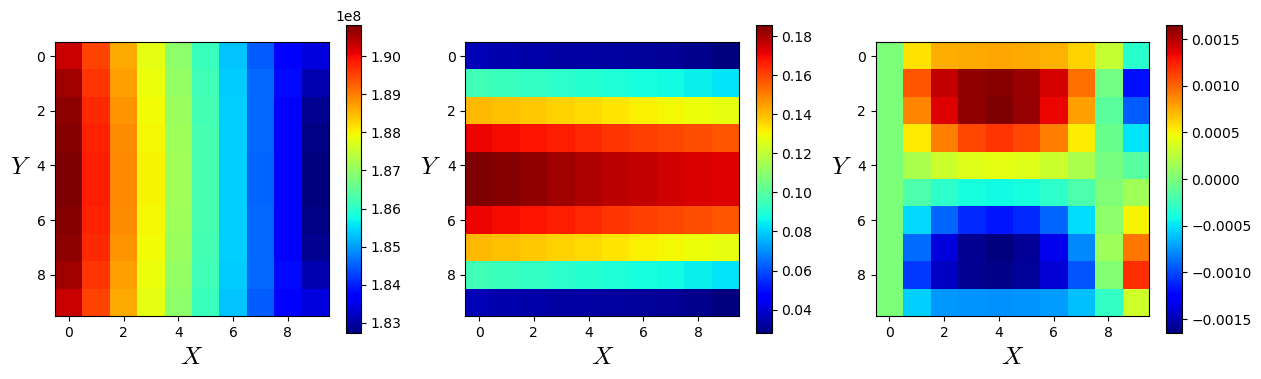

In [15]:
matplotlib.rcParams['mathtext.fontset'] = 'cm'
fig1, (ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(15,4))
img1=ax1.imshow(np.rot90(rhor[0][:,1:-1]),cmap='jet', interpolation='none')
fig1.colorbar(img1, ax=ax1)
ax1.set_xlabel('$X$',fontsize=18)
ax1.set_ylabel('$Y$',fontsize=18,horizontalalignment='right',rotation=0)
img2=ax2.imshow(np.rot90(Vxr[0][:,1:-1]),cmap='jet', interpolation='none')
fig1.colorbar(img2, ax=ax2)
ax2.set_xlabel('$X$',fontsize=18)
ax2.set_ylabel('$Y$',fontsize=18,horizontalalignment='right',rotation=0) 
img3=ax3.imshow(np.rot90(Vyr[0][:,1:-1]),cmap='jet', interpolation='none')
fig1.colorbar(img3, ax=ax3)
ax3.set_xlabel('$X$',fontsize=18)
ax3.set_ylabel('$Y$',fontsize=18,horizontalalignment='right',rotation=0) 

In [16]:
Nx0 = np.array([10, 20, 40],dtype="int64")
Ny0 = np.array([12, 22, 42],dtype="int64")
r0 = np.array([2.0**(3), 2.0**(4), 2.0**(5)],dtype="float64")
Vxana = np.empty(len(Nx0), dtype=object)
for i in range(len(Nx0)):
    Vxana[i] = np.zeros((int(Nx0[i]), int(Ny0[i])), dtype="float64")
for i in range(len(Nx0)):
    y=np.linspace(0.5, Ny0[i]-2 -0.5, Ny0[i]-2) / float(Ny0[i] - 2)
    for ix in range(Nx0[i]):
        Vxana[i][ix,1:-1]=6.0 * (1.0/r0[i]) * ( y - ( y )**2 );

Text(0, 0.5, '$Y$')

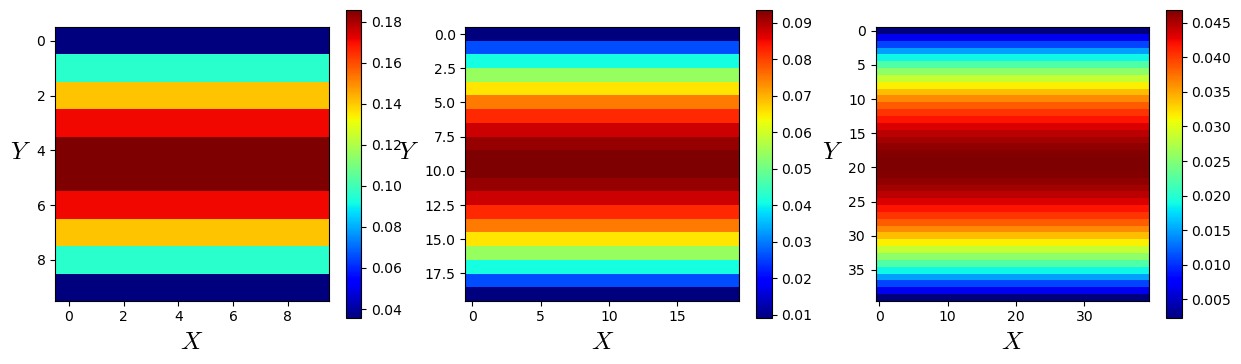

In [17]:
matplotlib.rcParams['mathtext.fontset'] = 'cm'
fig1, (ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(15,4))
img1=ax1.imshow(np.rot90(Vxana[0][:,1:-1]),cmap='jet', interpolation='none')
fig1.colorbar(img1, ax=ax1)
ax1.set_xlabel('$X$',fontsize=18)
ax1.set_ylabel('$Y$',fontsize=18,horizontalalignment='right',rotation=0)
img2=ax2.imshow(np.rot90(Vxana[1][:,1:-1]),cmap='jet', interpolation='none')
fig1.colorbar(img2, ax=ax2)
ax2.set_xlabel('$X$',fontsize=18)
ax2.set_ylabel('$Y$',fontsize=18,horizontalalignment='right',rotation=0) 
img3=ax3.imshow(np.rot90(Vxana[2][:,1:-1]),cmap='jet', interpolation='none')
fig1.colorbar(img3, ax=ax3)
ax3.set_xlabel('$X$',fontsize=18)
ax3.set_ylabel('$Y$',fontsize=18,horizontalalignment='right',rotation=0) 

In [18]:
E0=sqrt(sum((Vxr[0][:,:]-Vxana[0][:,:])**2))/sqrt(sum((Vxana[0][:,:])**2))
E1=sqrt(sum((Vxr[1][:,:]-Vxana[1][:,:])**2))/sqrt(sum((Vxana[1][:,:])**2))
E2=sqrt(sum((Vxr[2][:,:]-Vxana[2][:,:])**2))/sqrt(sum((Vxana[2][:,:])**2))

<>:10: SyntaxWarning: invalid escape sequence '\D'
<>:10: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_47784/2903882536.py:10: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta x$',fontsize=16)


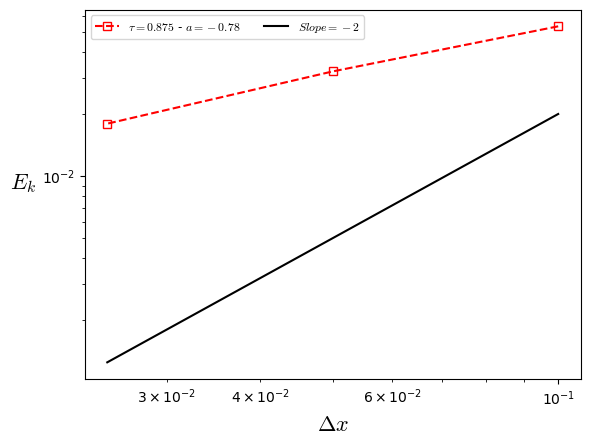

In [19]:
Malha=np.array([10,20,40])
Ek = np.array([E0,E1,E2])
TEk=np.polyfit(np.log(Malha), np.log(Ek), 1)
# Ek1 = np.array([0.000885053175400552,0.0002657329674660147,7.199195200913167e-05,1.8693115438450647e-05])
# TEk1=np.polyfit(np.log(Malha), np.log(Ek1), 1)
plt.loglog(1/Malha,Ek,'rs--',fillstyle='none')
# plt.loglog(1/Malha,Ek1,'bs--',fillstyle='none')
plt.loglog(1/Malha,2.0*1.0/(Malha**2),'k-',fillstyle='none')
plt.ylabel('$E_{k}$',fontsize=16,rotation=0,horizontalalignment='right')
plt.xlabel('$\Delta x$',fontsize=16)
plt.legend([fr'$\tau=0.875$ - $a={TEk[0]:.2f}$','$Slope=-2$'],loc=2,ncol=3,fontsize=8.5)

<>:6: SyntaxWarning: invalid escape sequence '\o'
<>:6: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_47784/3887496154.py:6: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel('$\overline{M}$',fontsize=16,rotation=0,horizontalalignment='right')


Text(0.5, 0, '$t$')

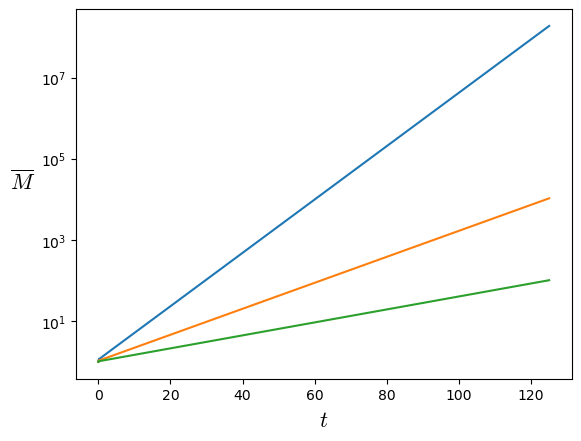

In [20]:
Nx0 = np.array([10, 20, 40],dtype="int64")
r0 = np.array([2.0**(3), 2.0**(4), 2.0**(5)],dtype="float64")
plt.semilogy(np.linspace(0,len(Mass[0]),len(Mass[0]))/Nx0[0]/r0[0],Mass[0])
plt.plot(np.linspace(0,len(Mass[1]),len(Mass[1]))/Nx0[1]/r0[1],Mass[1])
plt.plot(np.linspace(0,len(Mass[2]),len(Mass[2]))/Nx0[2]/r0[2],Mass[2])
plt.ylabel('$\overline{M}$',fontsize=16,rotation=0,horizontalalignment='right')
plt.xlabel('$t$',fontsize=16)